# Анализ клиентского опыта в приложении

В качестве исходных данных использовался лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в определённый период, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо было сформулировать рекомендации по распределению бюджета по разным рекламным каналам. 

**Задачи проекта:**   

- изучить, как люди пользуются продуктом,    
- когда они начинают покупать,    
- сколько денег приносит каждый клиент,    
- когда он окупается,    
- какие факторы отрицательно влияют на привлечение пользователей.

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    - User Id — уникальный идентификатор пользователя
    - Device — категория устройства пользователя
    - Session start — дата и время начала сессии
    - Session End — дата и время окончания сессии
    - Channel — идентификатор рекламного источника, из которого пришел пользователь
    - Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    - User Id — уникальный id пользователя, который сделал заказ
    - Event Dt — дата и время покупки
    - Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    - Channel — идентификатор рекламного источника
    - Dt — дата
    - Costs — затраты на этот рекламный источник в этот день

<a id='section_7'></a>

## СОДЕРЖАНИЕ ##


[Шаг 1. Подготовка данных](#section_1)   
[Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии](#section_2)   
[Шаг 3. Исследовательский анализ данных](#section_3)   
[Шаг 4. Маркетинг](#section_4)   
[Шаг 5. Оценка окупаемости рекламы для привлечения пользователей](#section_5)   
[Шаг 6. Выводы](#section_6)

## Шаг 1.  Подготовка данных
<a id='section_1'></a>

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
visits_with_organic = pd.read_csv('_.csv')
display(visits_with_organic.head(5))
visits_with_organic = visits_with_organic.rename(columns={'User Id': 'user_id', 'Region': 'region','Device': 'device','Channel': 'channel', 'Session Start': 'session_start', 'Session End': 'session_end'})
visits_with_organic['session_start'] = pd.to_datetime(visits_with_organic['session_start'])
visits_with_organic['session_end'] = pd.to_datetime(visits_with_organic['session_end'])
visits = visits_with_organic.query('channel != "organic"')

visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
Int64Index: 202141 entries, 3 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        202141 non-null  int64         
 1   region         202141 non-null  object        
 2   device         202141 non-null  object        
 3   channel        202141 non-null  object        
 4   session_start  202141 non-null  datetime64[ns]
 5   session_end    202141 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 10.8+ MB


In [3]:
orders = pd.read_csv('_.csv')
display(orders.head())
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [4]:
costs = pd.read_csv('_.csv')
display(costs.head())
costs = costs.rename(columns={'Channel': 'channel'}) 
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [5]:
visits.duplicated().sum()

0

In [6]:
orders.duplicated().sum()

0

In [7]:
costs.duplicated().sum()

0

Ни одна из исследуемых таблиц не содержит дубликатов.

[Вернуться к содержанию](#section_7)

## Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

<a id='section_2'></a>

**Функция для получения профилей пользователей**

In [8]:
def get_profiles(visits, orders, costs):
    
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first'
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )
    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

profiles = get_profiles(visits, orders, costs)
profiles['dt'] = profiles['dt'].astype('datetime64')

profiles.info()
profiles

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95048 entries, 0 to 95047
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           95048 non-null  int64         
 1   first_ts          95048 non-null  datetime64[ns]
 2   channel           95048 non-null  object        
 3   device            95048 non-null  object        
 4   region            95048 non-null  object        
 5   dt                95048 non-null  datetime64[ns]
 6   month             95048 non-null  datetime64[ns]
 7   payer             95048 non-null  bool          
 8   acquisition_cost  95048 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 6.6+ MB


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.076596
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.092857
2,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
3,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.214286
4,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
...,...,...,...,...,...,...,...,...,...
95043,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.832143
95044,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.111828
95045,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.441989
95046,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


**Функция для расчёта удержания**

In [9]:
def get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False
):
    
    dimensions = ['payer'] + dimensions
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        
        )
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id':'nunique'})
            .rename(columns={'user_id':'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
        
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    return result_raw, result_grouped, result_in_time

observation_date = datetime(2019, 11, 1).date()
analysis_horizon = 14

retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon)
display(retention)

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,82355,1.0,0.171016,0.083699,0.050161,0.032445,0.023969,0.018080,0.013818,0.011147,0.009228,0.007273,0.006205,0.005780,0.004553
True,7661,1.0,0.361572,0.276335,0.222686,0.200104,0.181177,0.158204,0.148153,0.137580,0.130140,0.128704,0.115520,0.112648,0.098812


**Функция для расчёта конверсии**

In [10]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        
        result = result.fillna(0).cumsum(axis = 1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)
        
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes
        
        return result
    
    result_grouped = round((group_by_dimensions(result_raw, dimensions, horizon_days)), 3)

    if 'cohort' in dimensions:
        dimensions = []
        
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['channel']
)

conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3801,0.094,0.101,0.103,0.107,0.109,0.110,0.112,0.112,0.112,0.113,0.113,0.114,0.114,0.114
FaceBoom,27759,0.103,0.110,0.112,0.114,0.116,0.116,0.117,0.118,0.118,0.119,0.119,0.120,0.120,0.120
LeapBob,8194,0.019,0.023,0.026,0.027,0.028,0.029,0.029,0.030,0.031,0.031,0.031,0.031,0.031,0.032
MediaTornado,4314,0.032,0.035,0.036,0.038,0.039,0.040,0.040,0.041,0.041,0.041,0.042,0.042,0.042,0.042
OppleCreativeMedia,8232,0.019,0.022,0.024,0.025,0.026,0.027,0.027,0.028,0.028,0.028,0.028,0.028,0.028,0.028
RocketSuperAds,4411,0.043,0.056,0.063,0.068,0.072,0.074,0.076,0.077,0.078,0.080,0.081,0.082,0.082,0.082
TipTop,18717,0.059,0.071,0.078,0.083,0.086,0.089,0.090,0.091,0.092,0.094,0.094,0.095,0.095,0.096
WahooNetBanner,8167,0.033,0.040,0.045,0.047,0.049,0.050,0.051,0.052,0.052,0.053,0.053,0.053,0.054,0.054
YRabbit,4282,0.034,0.036,0.039,0.040,0.041,0.042,0.043,0.043,0.043,0.044,0.044,0.044,0.044,0.045


**Функция для расчёта LTV и ROI**

In [11]:
def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum'
        )
        
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)
        
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        roi = result.div(cac['cac'], axis=0)
        
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        
        roi['cohort_size'] = cohort_sizes
        
        roi['cac'] = cac['cac']
        
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        return result, roi
    
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    return result_raw, round(result_grouped, 3), result_in_time, round(roi_grouped, 3), roi_in_time

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])

display(ltv)
display()
display(roi)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3801,0.705,0.788,0.848,0.896,0.925,0.950,0.979,0.993,1.018,1.033,1.041,1.051,1.067,1.079
FaceBoom,27759,0.614,0.689,0.729,0.757,0.777,0.790,0.805,0.815,0.824,0.833,0.839,0.846,0.852,0.856
LeapBob,8194,0.162,0.212,0.261,0.292,0.317,0.347,0.373,0.396,0.433,0.459,0.483,0.505,0.524,0.541
MediaTornado,4314,0.378,0.433,0.496,0.545,0.584,0.625,0.647,0.678,0.702,0.729,0.763,0.789,0.810,0.822
OppleCreativeMedia,8232,0.154,0.188,0.228,0.265,0.299,0.326,0.350,0.370,0.390,0.408,0.426,0.439,0.459,0.474
RocketSuperAds,4411,0.454,0.568,0.654,0.717,0.778,0.835,0.906,0.957,1.009,1.067,1.114,1.155,1.192,1.228
TipTop,18717,0.398,0.555,0.683,0.799,0.902,0.995,1.074,1.157,1.232,1.307,1.372,1.434,1.490,1.551
WahooNetBanner,8167,0.248,0.351,0.439,0.503,0.575,0.629,0.692,0.739,0.786,0.826,0.874,0.911,0.952,0.981
YRabbit,4282,0.384,0.437,0.484,0.535,0.590,0.622,0.648,0.674,0.695,0.716,0.739,0.766,0.793,0.810


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
AdNonSense,3801,0.982,0.718,0.802,0.864,0.912,0.942,0.968,0.997,1.012,1.037,1.052,1.060,1.071,1.087,1.099
FaceBoom,27759,1.105,0.555,0.624,0.660,0.685,0.703,0.715,0.729,0.738,0.746,0.754,0.759,0.766,0.771,0.775
LeapBob,8194,0.208,0.781,1.021,1.259,1.407,1.525,1.669,1.798,1.905,2.086,2.210,2.327,2.430,2.523,2.605
MediaTornado,4314,0.212,1.785,2.048,2.345,2.574,2.761,2.953,3.057,3.204,3.319,3.446,3.605,3.730,3.829,3.886
OppleCreativeMedia,8232,0.247,0.622,0.762,0.923,1.072,1.210,1.318,1.416,1.499,1.577,1.653,1.725,1.777,1.858,1.917
RocketSuperAds,4411,0.402,1.128,1.411,1.624,1.782,1.933,2.074,2.252,2.378,2.508,2.653,2.769,2.870,2.964,3.054
TipTop,18717,2.726,0.146,0.204,0.251,0.293,0.331,0.365,0.394,0.425,0.452,0.480,0.503,0.526,0.547,0.569
WahooNetBanner,8167,0.596,0.417,0.589,0.737,0.844,0.966,1.055,1.162,1.241,1.319,1.386,1.467,1.530,1.598,1.647
YRabbit,4282,0.208,1.848,2.102,2.326,2.575,2.838,2.989,3.118,3.242,3.342,3.443,3.555,3.684,3.814,3.893


In [12]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

**Функция для визуализации удержания пользователей**

In [13]:
def plot_retention (retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15,10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
        
    ax1 = plt.subplot(2,2,1)
    retention.query('payer == True').droplevel('payer').T.plot(grid = True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    
    ax2 = plt.subplot(2,2,2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    
    ax3 = plt.subplot(2,2,3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    ax4 = plt.subplot(2,2,4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index = 'dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день.'.format(horizon))
    
    plt.tight_layout()
    plt.show()

**Функция для визуализации конверсии**

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    
    plt.figure(figsize=(15,5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    ax1 = plt.subplot(1,2,1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    
    ax2 = plt.subplot(1,2,2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'    
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день.'.format(horizon))
    
    plt.tight_layout()
    plt.show()

**Визуализация LTV и ROI** 

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])

    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

[Вернуться к содержанию](#section_7)

# Шаг 3. Исследовательский анализ данных
<a id='section_3'></a>

Профили пользователей. Минимальная и максимальная дата привлечения пользователей.

In [16]:
profiles = get_profiles(visits, orders, costs)
pd.set_option('display.float_format', '{:.3f}'.format)

profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.077
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.093
2,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988
3,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.214
4,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008


In [17]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

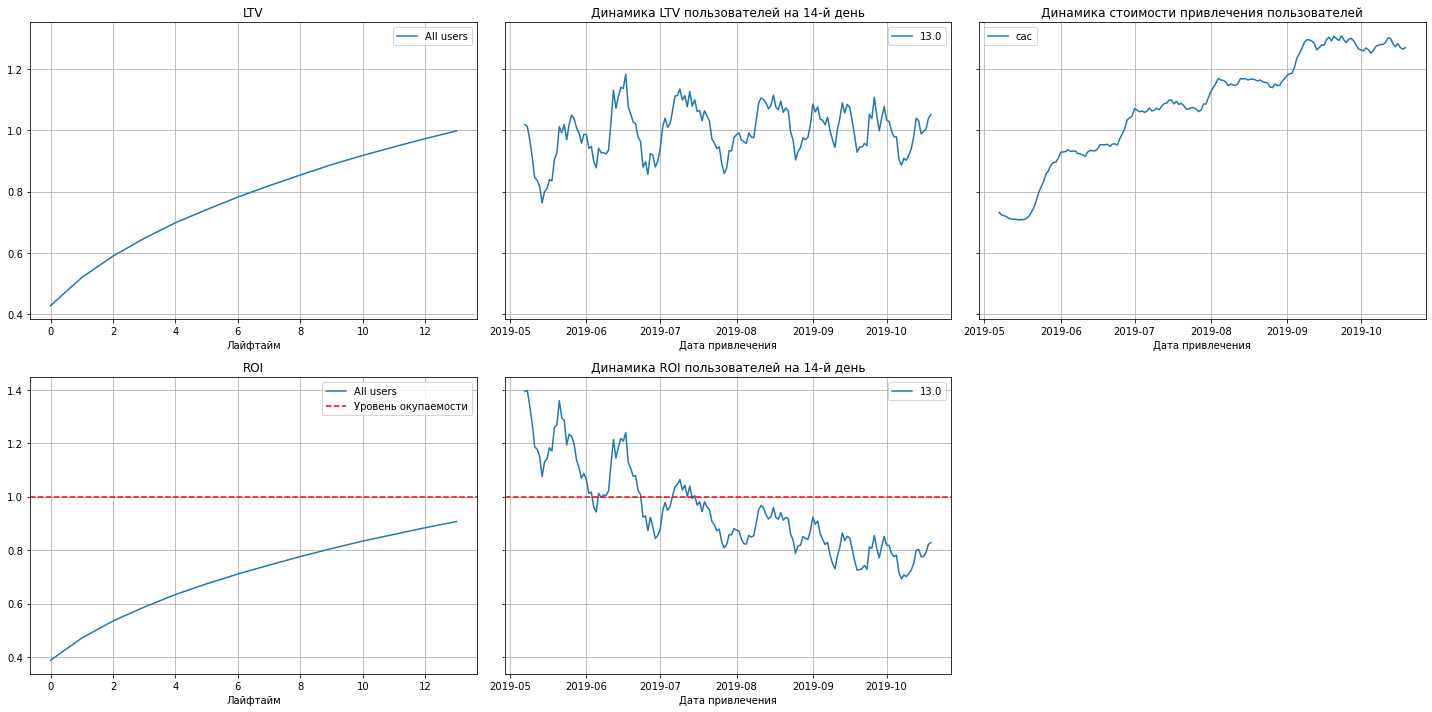

In [18]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из графиков можно сделать следующие выводы:   
1. Реклама не окупается, но стремится к этому и почти достигает уровня окупаемости к концу исследуемого периода;  
2. Стоимость привлечения пользователей резко возросла в июне и продолжает расти весь исследуемый период;   
3. LTV стабилен.

In [19]:
print(profiles.groupby('region').agg({'payer': 'mean', 'user_id': 'nunique'}).sort_values(by='payer', ascending=False))

               payer  user_id
region                       
United States  0.101    62822
Germany        0.055     9682
UK             0.054    11325
France         0.053    11219


Пользователи приходят из Франции, Германии, Великобритании и США.   
Больше всего пользователей приходит из США, для этой же страны характерна самая большая доля платящих  пользователей

In [20]:
print(profiles.groupby('device').agg({'payer': 'mean', 'user_id': 'nunique'}).sort_values(by='payer', ascending=False))

         payer  user_id
device                 
Mac      0.092    18989
iPhone   0.091    34433
Android  0.084    22163
PC       0.070    19463


Пользователи используют PC, Mac, Android, IPhone.   
Платящие пользователи чаще всего заходят с IPhone. Этим же устройством пользуются чаще всего. 

In [21]:
print(profiles.groupby('channel').agg({'payer': 'mean', 'user_id': 'nunique'}).sort_values(by='payer', ascending=False))

                    payer  user_id
channel                           
FaceBoom            0.123    29373
AdNonSense          0.120     3988
lambdaMediaAds      0.108     2236
TipTop              0.098    19794
RocketSuperAds      0.088     4622
WahooNetBanner      0.055     8645
YRabbit             0.046     4507
MediaTornado        0.045     4526
LeapBob             0.033     8649
OppleCreativeMedia  0.030     8708


Привлечение пользователей проходит через 10 каналов, кроме органического.   
Больше всего платящих пользователей приходит через FaceBoom.

Промежуточный итог: большая часть маркетингового бюджета должна направляться на FaceBoom для пользователей из США, которые ипользуют PC для приложения.

[Вернуться к содержанию](#section_7)

# Шаг 4. Маркетинг

<a id='section_4'></a>

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [22]:
print('Общие затраты на рекламу за исследуемый период составили', round(costs['costs'].sum(), 3))

Общие затраты на рекламу за исследуемый период составили 105497.3


In [23]:
print('Затраты на рекламу на каждый источник')
print(costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False))

Затраты на рекламу на каждый источник
                       costs
channel                     
TipTop             54751.300
FaceBoom           32445.600
WahooNetBanner      5151.000
AdNonSense          3911.250
OppleCreativeMedia  2151.250
RocketSuperAds      1833.000
LeapBob             1797.600
lambdaMediaAds      1557.600
MediaTornado         954.480
YRabbit              944.220


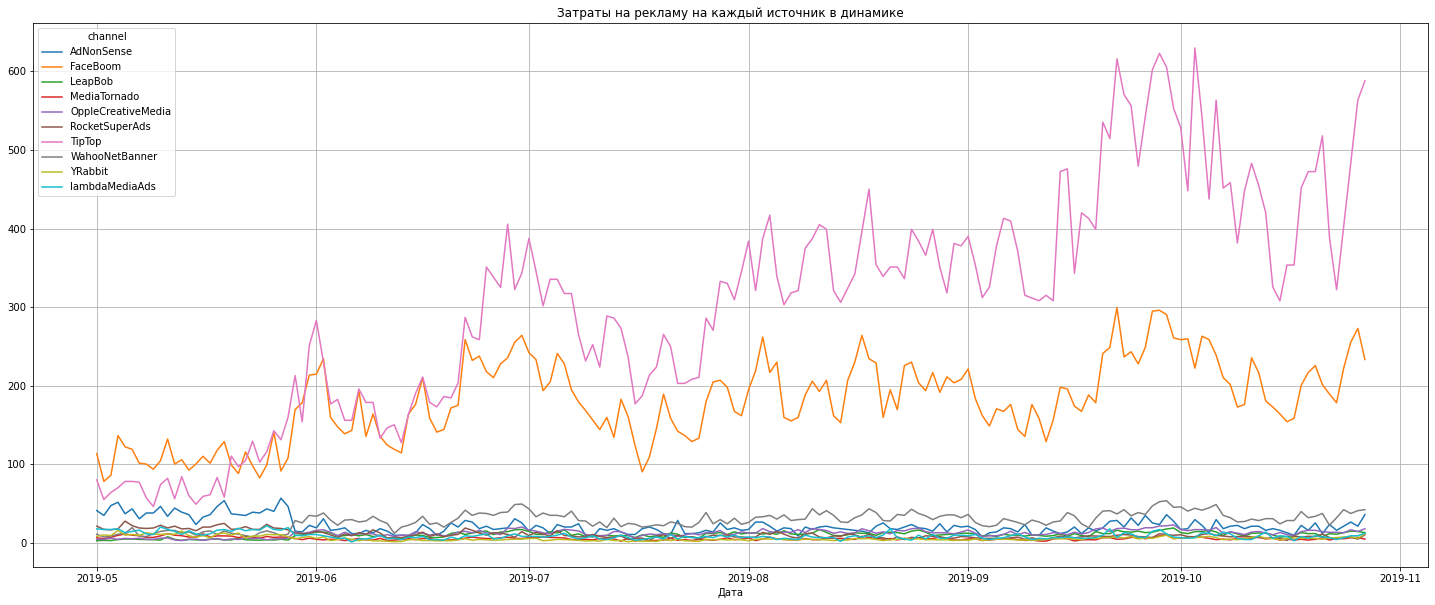

In [24]:
costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(25,10))

plt.title('Затраты на рекламу на каждый источник в динамике')
plt.xlabel('Дата')
plt.show()

Затраты на рекламу в источниках FaceBoom и TipTop растут в течение изучаемого периода. В этих же каналах самая высокая стоимость привлечения одного покупателя.

In [25]:
print('Средняя стоимость привлечения одного покупателя из каждого источника.')
profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
).sort_values('acquisition_cost', ascending=False)

Средняя стоимость привлечения одного покупателя из каждого источника.


,acquisition_cost
channel,
TipTop,2.766
FaceBoom,1.105
AdNonSense,0.981
lambdaMediaAds,0.697
WahooNetBanner,0.596
RocketSuperAds,0.397
OppleCreativeMedia,0.247
MediaTornado,0.211
YRabbit,0.210


In [26]:
print('общий САС по проекту', round((costs['costs'].sum()/visits['user_id'].nunique()), 3))

общий САС по проекту 1.11


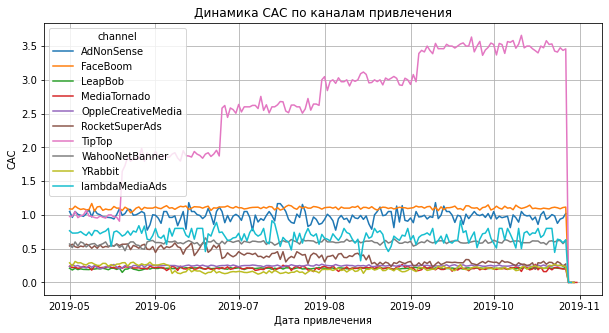

In [27]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Стоимость привлечения одного клиента по проекту - 1,1. Тогда как стоимость привлечения пользователя из канала Tip Top доходит до 3,5, а 3 канала колеблятся в районе 1,0.

[Вернуться к содержанию](#section_7)

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

<a id='section_5'></a>

### Проанализируйте общую окупаемость рекламы

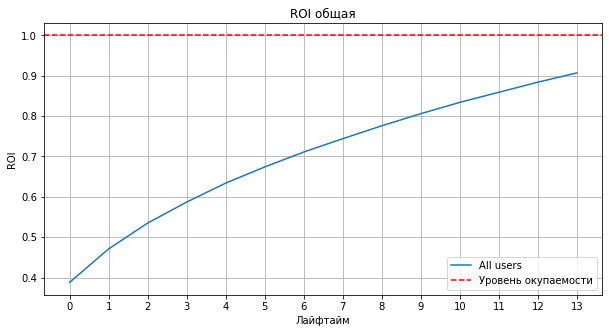

In [28]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14)

report = roi.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI общая')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

В общем, реклама не окупается. 

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

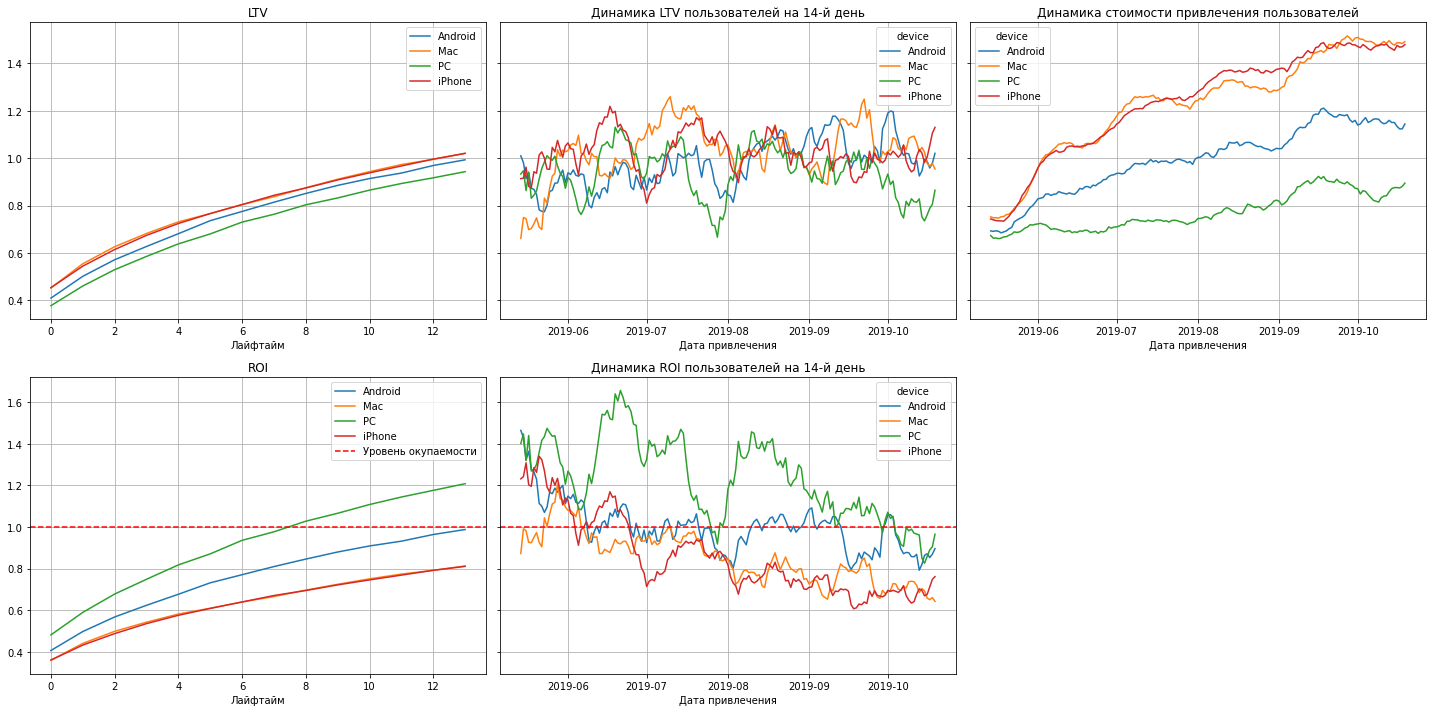

In [29]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Если рассматривать окупаемость по устройствам, то окупаются пользователи PC.   
Стоимость привлечения постоянно растёт, причём самыми большими темпами у тех устройств, которые не окупаются. 

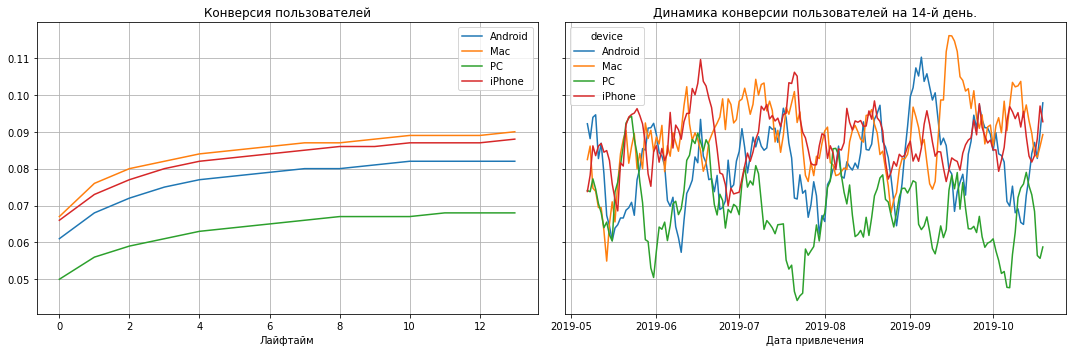

In [30]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия стабильна по всем устройствам.

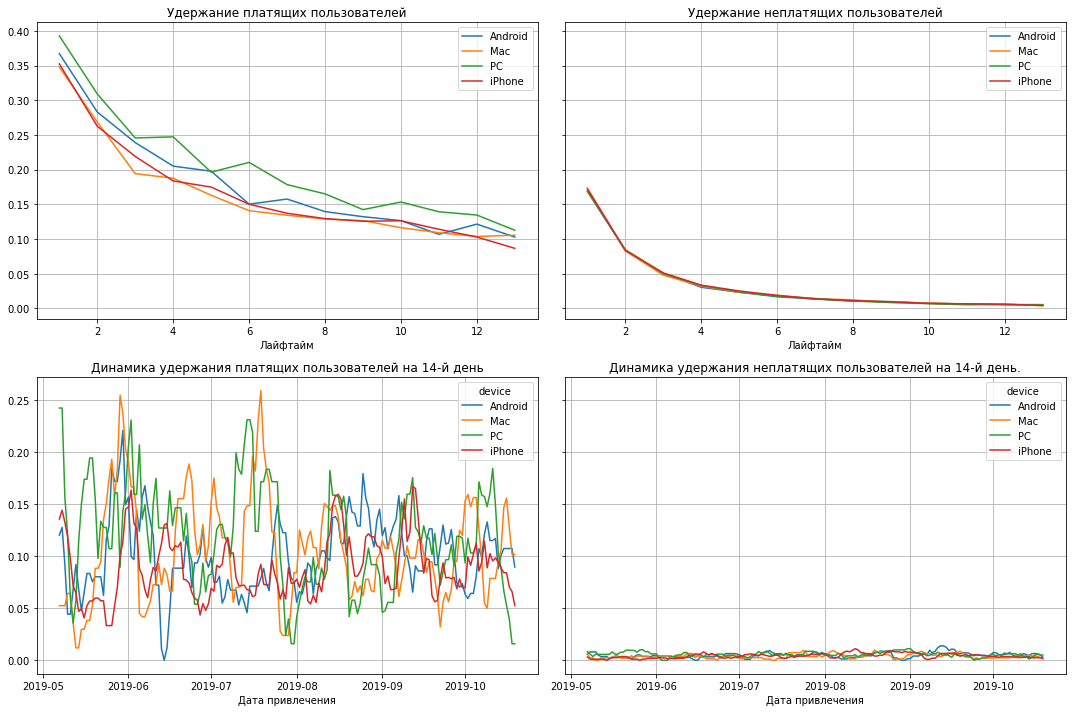

In [31]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Проанализируйте окупаемость рекламы с разбивкой по странам

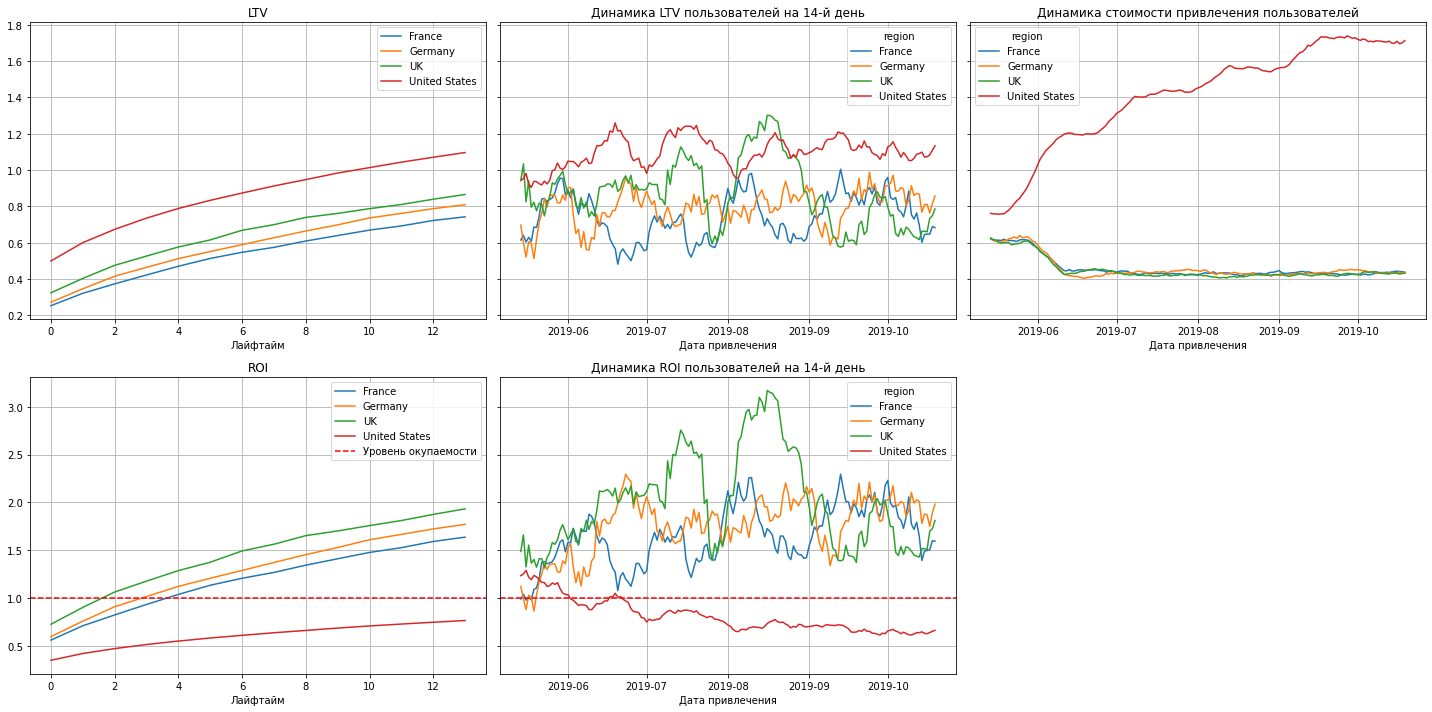

In [32]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Несмотря на то, что в предыдущих пунктах мы выявили то, что из США самое большое количество платящих пользователей в абсолютном показателе, в относительных величинах пользователи из США не окупаются. Эти же пользователи имеют самую большую стоимость привлечения, которая растёт.

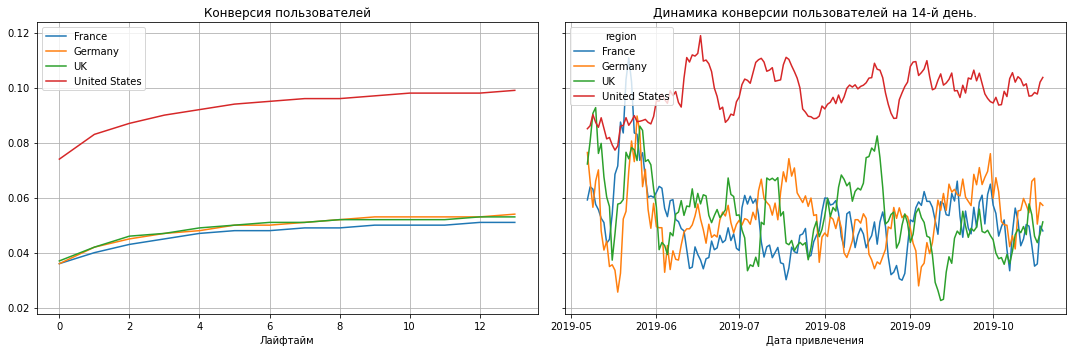

In [33]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия у пользователей из США самая высокая, а удержание - самое низкое.

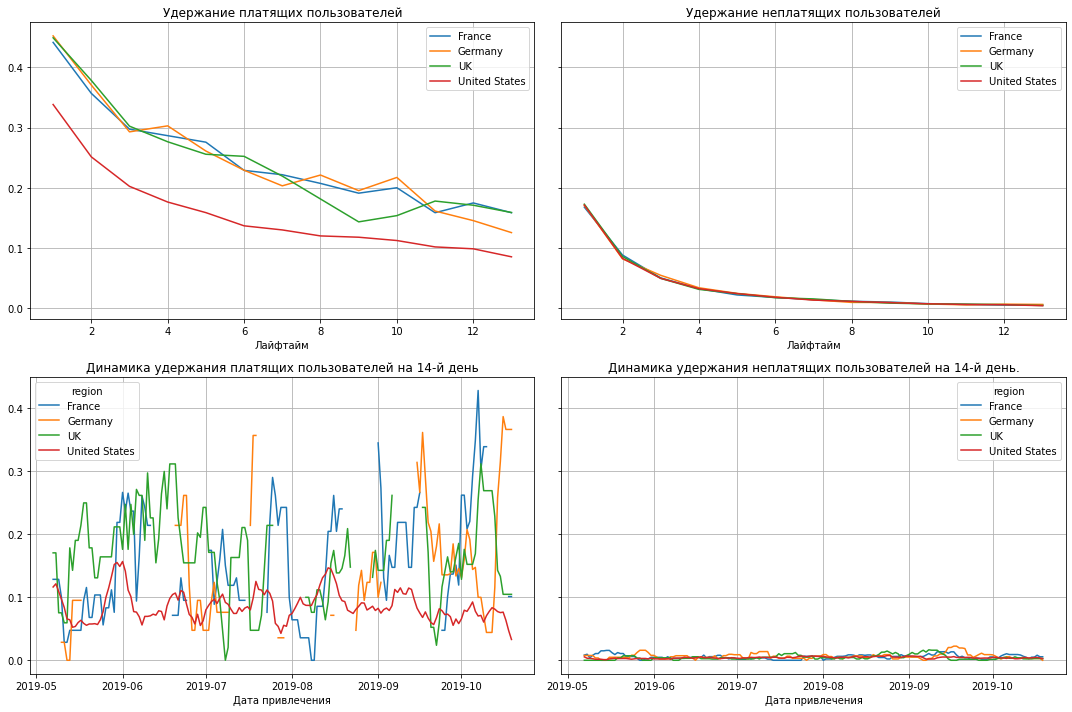

In [34]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

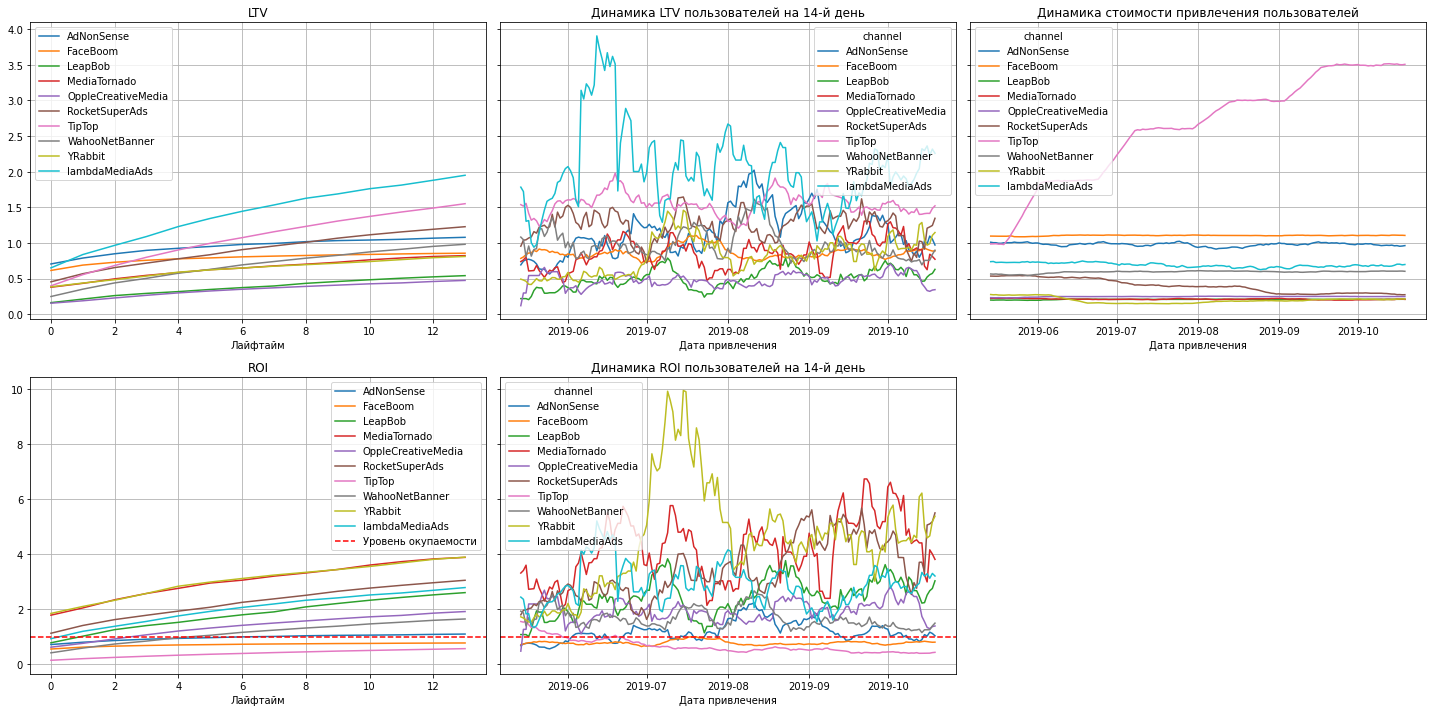

In [35]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Не окупаются пользователи из каналов FaceBoom и Tip Top. Стоимость привлечения пользователей через канал Tip Top постоянно увеличивается. В сочетании с отсутсвием окупаемости использование этого канала привлечения = сливу маркетингового бюджета. 

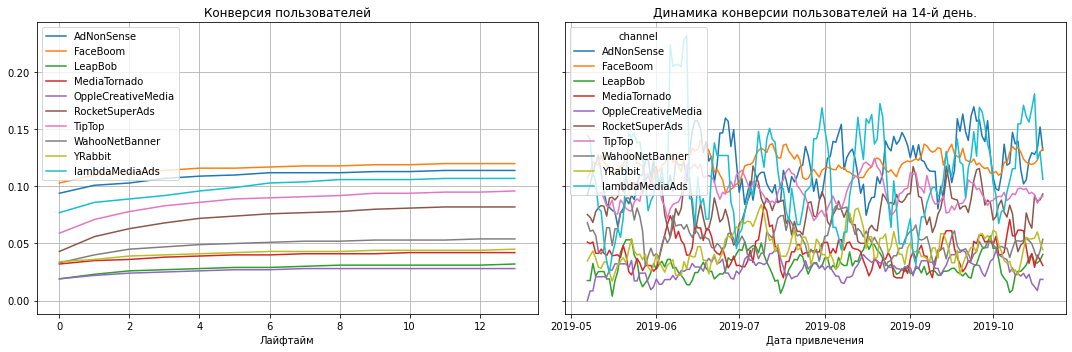

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

На момент начала рекламной компании у FaceBoom была самая высокая конверсия.

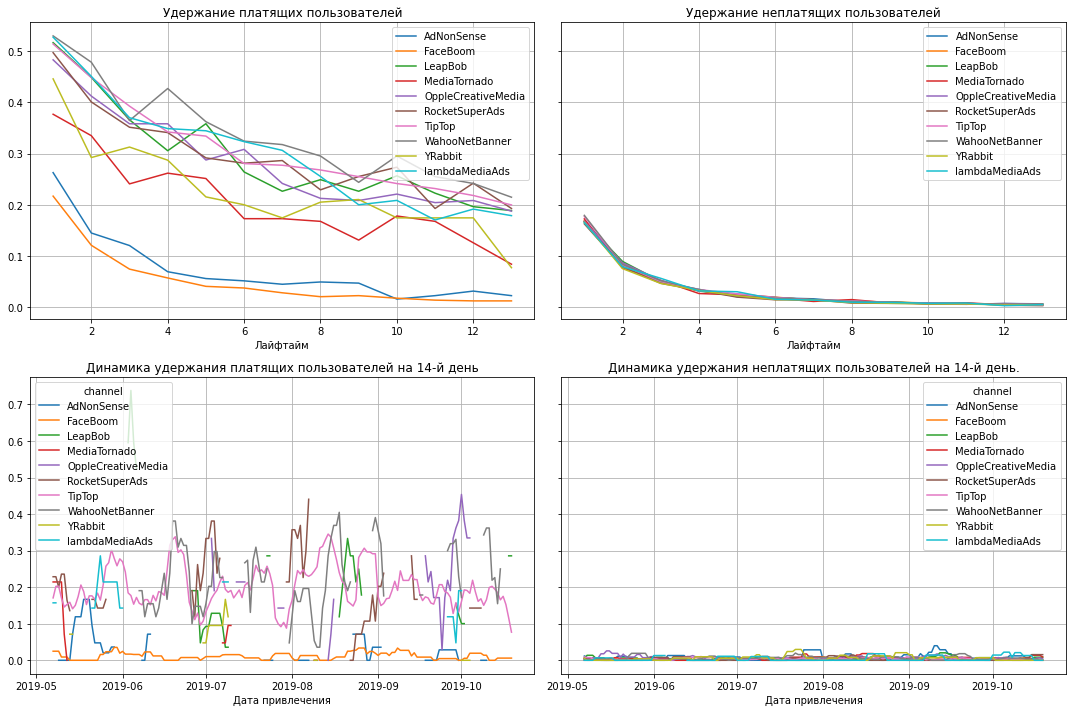

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Самое низкое удержание объясняет отсутвие эффективности бюджета этого рекламного канала.

# Шаг 6. Выводы
<a id='section_6'></a>

Сложившуюся ситуацию можно обосновать следующим сценарием: 

- аналитика по каналам проводилась только на начальном этапе рекламной компании   
- следующие месяцы решения принимались на основе показателей, рассчитанных в первый месяц   
- именно это и привело к сложившейся затруднительной экономической ситуации


Рекомендации:   
- ежемесячно обращаться к аналитику данных за детальными показателями эффективности рекламного бюджета
- отказаться от рекламных каналов Tip Top, AdNonSense и FaceBoom, т.к. они не окупаются   
- привлечение пользователей из США обходится неоправдано дорого, если нам необходимо оптимизировать бюджет, то стоит сократить бюджет на привлечение этих пользователей   
- пользователи на MAC и IPhone не окупаются, стоит преимущественно ориентироваться на пользователей PC и Android.